In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

# Reading labels

## `ClassConfig`

Before we can work with labels, we first want to define what our target classes are -- their names, their IDs, and possibly, their colors (to use for visualization).

.. currentmodule:: rastervision.core.data

Raster Vision makes all this simple to do using the handy :class:`.ClassConfig` class.

In [2]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(names=['background', 'foreground'])
class_config

2023-10-20 17:40:29:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /data/tmp. Using root: /data/tmp/tmp8kz_29ur


ClassConfig(names=['background', 'foreground'], colors=[(245, 187, 82), (217, 126, 133)], null_class=None)

(Note how a unique color was generated for each class.)

The numeric ID of each class is its index in the :attr:`~class_config.ClassConfig.names` list.

We can query the ID of a class like so:

In [3]:
print('background', class_config.get_class_id('background'))
print('foreground', class_config.get_class_id('foreground'))

background 0
foreground 1


In the example above, `ClassConfig` automatically generated a color for each class. We could have instead manually specified them. The colors can be any color-string recognized by `PIL`.

In [4]:
class_config = ClassConfig(
    names=['background', 'foreground'],
    colors=['lightgray', 'darkred'])
class_config

ClassConfig(names=['background', 'foreground'], colors=['lightgray', 'darkred'], null_class=None)

---

### The "null" class

Geospatial rasters can have `NODATA` pixels. This is relevant for semantic segmentation where you need to assign a label to every pixel.

You may either want to assign them a class of their own or consider them a part of a catch-all "background" class.

`ClassConfig`'s name for this class is the "null class". Below are some ways that you can define it.

1. Designate one class as the "null" class.

In [5]:
class_config = ClassConfig(names=['background', 'foreground'], null_class='background')
class_config

ClassConfig(names=['background', 'foreground'], colors=[(33, 182, 204), (204, 247, 82)], null_class='background')

2. Specify a class called "null".

In [6]:
class_config = ClassConfig(names=['null', 'foreground'])
class_config

ClassConfig(names=['null', 'foreground'], colors=[(14, 230, 234), (250, 106, 200)], null_class='null')

3. Call `.ensure_null_class()` to automatically add an additional "null" class.

In [7]:
class_config = ClassConfig(names=['background', 'foreground'])
class_config.ensure_null_class()
class_config

ClassConfig(names=['background', 'foreground', 'null'], colors=[(30, 250, 201), (125, 87, 199), 'black'], null_class='null')

---

### Normalized colors

Another nifty functionality is the :attr:`~class_config.ClassConfig.color_triples` property that returns the colors in a normalized form that can be directly used with ``matplotlib``.

The example below shows how we can easily create a color-map from our class colors.

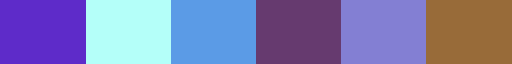

In [8]:
from matplotlib.colors import ListedColormap

class_config = ClassConfig(names=['a', 'b', 'c', 'd', 'e', 'f'])
cmap = ListedColormap(class_config.color_triples)
cmap

<hr style="border:2px solid gray">

## `LabelSource`

.. currentmodule:: rastervision.core.data.label_source

While `RasterSources <reading_raster_data.ipynb>`_ and `VectorSources <reading_vector_data.ipynb>`_ allow us to read raw data, the :class:`LabelSources <label_source.LabelSource>` take this data and convert them into a form suitable for machine learning.

We have 3 kinds of pre-defined :class:`LabelSources <label_source.LabelSource>` -- one for each of the 3 main computer vision tasks: semantic segmentation, object detection, and chip classification.

---

### Semantic Segmentation - `SemanticSegmentationLabelSource`

:class:`.SemanticSegmentationLabelSource` is perhaps the simplest of `LabelSources`. Since semantic segmentation labels are rasters themselves, :class:`.SemanticSegmentationLabelSource` takes in a :class:`.RasterSource` and allows querying chips from it using array-indexing or :class:`Box's <rastervision.core.box.Box>`.

The main added service it provides is ensuring that if a chip overflows the extent, the overflowing pixels are assigned the ID of the "null class".

---

The example below shows how to create a `SemanticSegmentationLabelSource` from rasterized vector labels.

In [9]:
import os
from subprocess import check_output

os.environ['GDAL_DATA'] = check_output('pip show rasterio | grep Location | awk \'{print $NF"/rasterio/gdal_data/"}\'', shell=True).decode().strip()
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [10]:
# img_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/RGB-PanSharpen_AOI_2_Vegas_img205.tif'
# label_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/buildings_AOI_2_Vegas_img205.geojson'
img_uri = 'RGB-PanSharpen_AOI_2_Vegas_img205.tif'
label_uri = 'buildings_AOI_2_Vegas_img205_3.geojson'

Define `ClassConfig`:

In [11]:
# read the geojson file in label_uri to a geopandas dataframe
import geopandas as gpd
labelsxx = gpd.read_file(label_uri)
labelsxx.head()

,class_id,FID_VEGAS_,Id,FID_Vegas,Name,AREA,Shape_Leng,Shape_Le_1,SISL,OBJECTID_1,Shape_Le_2,Shape_Le_3,Shape_Area,partialBuilding,partialDec,geometry
0,1.5,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000625,0.0,0.0,1.0,"POLYGON Z ((-115.30076 36.19516 0.00000, -115...."
1,1.0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000658,0.0,0.0,1.0,"POLYGON Z ((-115.30074 36.19530 0.00000, -115...."
2,1.0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000627,0.0,0.0,1.0,"POLYGON Z ((-115.30076 36.19548 0.00000, -115...."
3,1.5,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000744,0.0,0.0,1.0,"POLYGON Z ((-115.30076 36.19573 0.00000, -115...."
4,1.5,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000634,0.0,0.0,1.0,"POLYGON Z ((-115.30081 36.19589 0.00000, -115...."


In [12]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['background', 'building','test'], 
    colors=['lightgray', 'darkred', 'green'],
    null_class='background')

.. currentmodule:: rastervision.core.data

Create

- a :class:`.RasterSource` to get the image extent and a :class:`~crs_transformer.crs_transformer.CRSTransformer`
- a :class:`.VectorSource` to read the vector labels
- a :class:`.RasterizedSource` to rasterize the :class:`.VectorSource`

In [13]:
from rastervision.core.data import (
    ClassInferenceTransformer, GeoJSONVectorSource,
    RasterioSource, RasterizedSource)

from utils.rastervision_pipeline import RasterizedSourceProbability

img_raster_source = RasterioSource(img_uri, allow_streaming=True)

vector_source = GeoJSONVectorSource(
    label_uri,
    img_raster_source.crs_transformer,
    ignore_crs_field=True,
    vector_transformers=[
        ClassInferenceTransformer(
            default_class_id=class_config.get_class_id('building'))])

label_raster_source = RasterizedSourceProbability(
    vector_source,
    background_class_id=class_config.null_class_id,
    extent=img_raster_source.extent)

# label_raster_source = RasterizedSource(
#     vector_source,
#     background_class_id=class_config.null_class_id,
#     extent=img_raster_source.extent)

2023-10-20 17:40:34:rastervision.core.data.raster_source.rasterio_source: WARNING - Raster block size (2, 650) is too non-square. This can slow down reading. Consider re-tiling using GDAL.


Create a `SemanticSegmentationLabelSource` from the `RasterizedSource`.

In [14]:
from rastervision.core.data import SemanticSegmentationLabelSource

label_source = SemanticSegmentationLabelSource(
    label_raster_source, class_config=class_config)

We can sample label-chips like so:

In [15]:
label_chip = label_source[:, :]

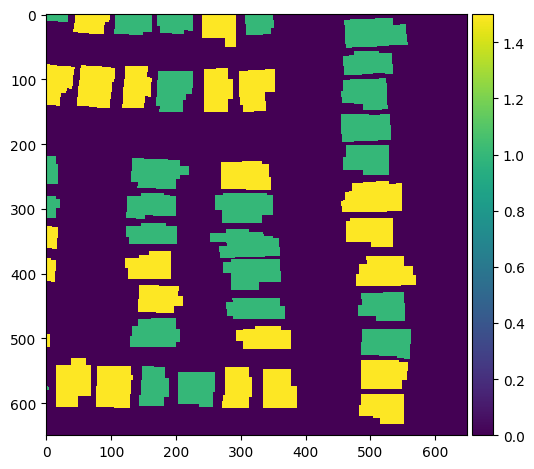

In [16]:
import skimage.io as skio
skio.imshow(label_chip)

In [17]:
label_chip

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

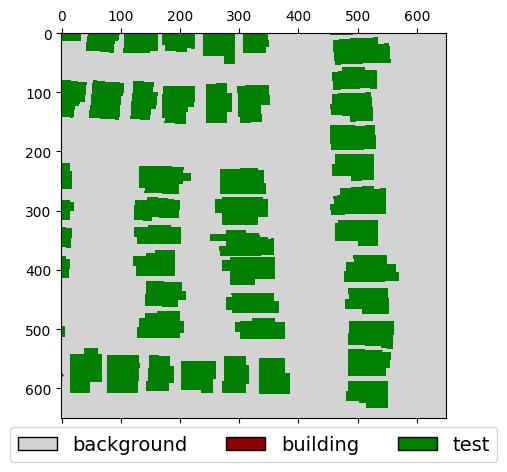

In [18]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import patches

fig, ax = plt.subplots(figsize=(5, 5))
cmap = ListedColormap(class_config.color_triples)
ax.matshow(label_chip, cmap=cmap)

legend_items = [
    patches.Patch(facecolor=cmap(i), edgecolor='black', label=cname)
    for i, cname in enumerate(class_config.names)]
ax.legend(
    handles=legend_items, 
    ncol=len(class_config), 
    loc='upper center', 
    fontsize=14,
    bbox_to_anchor=(0.5, 0))
plt.show()